Feature Importances

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt

#Run this before splitting and modeling
df = pd.read_csv('/Users/christineyao/Downloads/survey.csv')
#Drop columns
df = df.drop(['comments'], axis= 1)
df = df.drop(['Timestamp'], axis= 1)
df = df.drop(['state'], axis = 1)
df.columns

Index(['Age', 'Gender', 'Country', 'self_employed', 'family_history',
       'treatment', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'],
      dtype='object')

In [2]:

from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import xgboost

y = df['treatment'].map({'No': 0, 'Yes': 1})

# the target variable
y = df['treatment']
df.drop(columns=['treatment'],inplace=True)

# the unprocessed feature matrix
X = df.values
print(f'feature matrix size: {X.shape}')

# the feature names
ftrs = df.columns

#Gender cleaning
df["Gender"].replace(['array of values and mispellings'], 'replaced value', inplace = True)
df['Gender'].replace(['Male ', 'male', 'M', 'm', 'Male', 'Cis Male',
                     'Man', 'cis male', 'Mail', 'Male-ish', 'Male (CIS)',
                     'Cis Man', 'msle', 'Malr', 'Mal', 'maile', 'Make',], 'Male', inplace = True)
df['Gender'].replace(['Female ', 'female', 'F', 'f', 'Woman', 'Female',
                     'femail', 'Cis Female', 'cis-female/femme', 'Femake', 'Female (cis)',
                     'woman',], 'Female', inplace = True)
df["Gender"].replace(['Female (trans)', 'queer/she/they', 'non-binary',
                      'fluid', 'queer', 'Androgyne', 'Trans-female', 'male leaning androgynous',
                      'Agender', 'A little about you', 'Nah', 'All',
                      'ostensibly male, unsure what that really means', 
                      'Genderqueer', 'Enby', 'p', 'Neuter', 'something kinda male?',
                      'Guy (-ish) ^_^', 'Trans woman',], 'Other', inplace = True)


df.loc[df.Age> 80, ["Age"]] = df["Age"].median()
df.loc[df.Age< 18, ["Age"]] = df["Age"].median()

#Create new category for the people who don't have mental illness and cannot answer the question
#work_interfere: If you have a mental health condition, do you feel that it interferes with your work?
df['work_interfere'] = df['work_interfere'].fillna('Not Applicable')

#Impute the self_employed 
df['self_employed'].fillna('No', inplace = True)


feature matrix size: (1259, 23)


/var/folders/vv/7dp6x9hx2pj3bxcnxndv1fpw0000gn/T/ipykernel_39327/1873189015.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Gender"].replace(['array of values and mispellings'], 'replaced value', inplace = True)
/var/folders/vv/7dp6x9hx2pj3bxcnxndv1fpw0000gn/T/ipykernel_39327/1873189015.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedia

In [3]:
#split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(f'train size: {X_train.shape}')
print(f'validation size: {X_CV.shape}')
print(f'test size: {X_test.shape}')

train size: (755, 23)
validation size: (252, 23)
test size: (252, 23)


In [4]:
# Collect the Features

cat_ftrs = ['Gender', 'Country', 'self_employed', 'family_history', 'remote_work', 
    'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help',
    'anonymity', 'mental_health_consequence', 'phys_health_consequence',
    'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
    'mental_vs_physical', 'obs_consequence']
ordinal_ftrs = ['work_interfere', 'no_employees', 'leave']
ordinal_cats = [['Never', 'Rarely', 'Sometimes', 'Often', 'Not Applicable'], #The not applicable category was added because it was not something I should impute if people don't have mental isseus
    ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'], 
    ['Very difficult', 'Somewhat difficult', 'Somewhat easy', 'Very easy', "Don't know"]]
num_ftrs = ['Age']

In [5]:
# Transformers
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # handle_unknown='ignore' avoids unseen categories error

ordinal_transformer = Pipeline(steps=[ 
    ('ordinal', OrdinalEncoder(categories=ordinal_cats))])  # Specify categories for ordinal encoding

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)
    ]
)

In [6]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)  # Fit and transform training data
print(f"Shape of X_prep: {X_prep.shape}")

# Extract feature names after fitting the preprocessor
feature_names = preprocessor.get_feature_names_out()
print(f"Number of features from preprocessor: {len(feature_names)}")

# Check if X_prep is sparse; convert if necessary
if hasattr(X_prep, "toarray"):
    X_prep = X_prep.toarray()

# Create DataFrame for preprocessed training data
df_train = pd.DataFrame(data=X_prep, columns=feature_names)
print(f"Preprocessed train size: {df_train.shape}")

# Transform the validation set (CV)
X_CV_prep = preprocessor.transform(X_CV)
if hasattr(X_CV_prep, "toarray"):
    X_CV_prep = X_CV_prep.toarray()

df_CV = pd.DataFrame(data=X_CV_prep, columns=feature_names)
print(f"Preprocessed validation size: {df_CV.shape}")

# Transform the test set
X_test_prep = preprocessor.transform(X_test)
if hasattr(X_test_prep, "toarray"):
    X_test_prep = X_test_prep.toarray()

df_test = pd.DataFrame(data=X_test_prep, columns=feature_names)
print(f"Preprocessed test size: {df_test.shape}")


Shape of X_prep: (755, 94)
Number of features from preprocessor: 94
Preprocessed train size: (755, 94)
Preprocessed validation size: (252, 94)
Preprocessed test size: (252, 94)


In [51]:
print(df_train.info())
print(df_CV.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 94 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   num__Age                              755 non-null    float64
 1   cat__Gender_Female                    755 non-null    float64
 2   cat__Gender_Male                      755 non-null    float64
 3   cat__Gender_Other                     755 non-null    float64
 4   cat__Country_Australia                755 non-null    float64
 5   cat__Country_Austria                  755 non-null    float64
 6   cat__Country_Bahamas, The             755 non-null    float64
 7   cat__Country_Belgium                  755 non-null    float64
 8   cat__Country_Brazil                   755 non-null    float64
 9   cat__Country_Bulgaria                 755 non-null    float64
 10  cat__Country_Canada                   755 non-null    float64
 11  cat__Country_Colomb

In [8]:
# Encode labels if they are categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_CV = le.transform(y_CV)
y_test = le.transform(y_test)


In [9]:
# import necessary libraries for xgboost 
import xgboost
from sklearn.model_selection import ParameterGrid


# parameters to try 
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

# create xgboost model and set parameters 
XGB = xgboost.XGBClassifier(early_stopping_rounds=50)
XGB.set_params(**ParameterGrid(param_grid)[0])

# fit model to train data 
model = XGB.fit(df_train,y_train,eval_set=[(df_CV, y_CV)], verbose=False)

# predict on validation 
y_CV_pred = XGB.predict(df_CV)
print('the CV accuracy:', accuracy_score(y_CV,y_CV_pred))

# predict on test 
y_test_pred = XGB.predict(df_test)
print('the test accuracy:', accuracy_score(y_test,y_test_pred))


the CV accuracy: 0.8531746031746031
the test accuracy: 0.8095238095238095


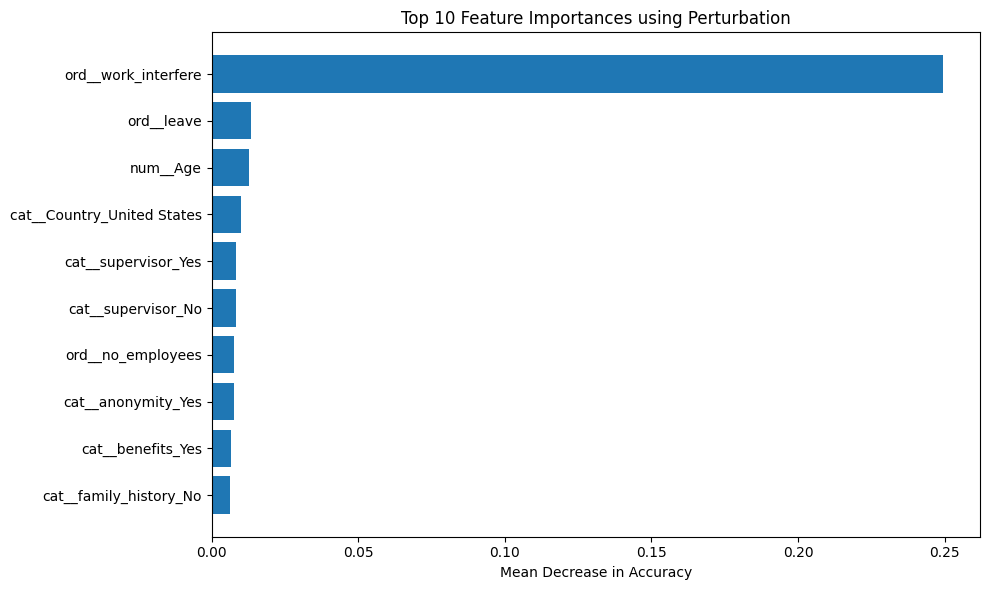

In [18]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# Compute permutation importance
perm_importance = permutation_importance(model, df_test, y_test, n_repeats=10, random_state=42)

# Extract and sort feature importances
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
top_10_idx = sorted_idx[:10]  # Select top 10 features
top_features = [feature_names[i] for i in top_10_idx]

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], perm_importance.importances_mean
         [top_10_idx][::-1])
plt.xlabel("Mean Decrease in Accuracy")
plt.title("Top 10 Feature Importances using Perturbation")
plt.tight_layout()
plt.savefig('perturbation.png', dpi = 500)
plt.show()

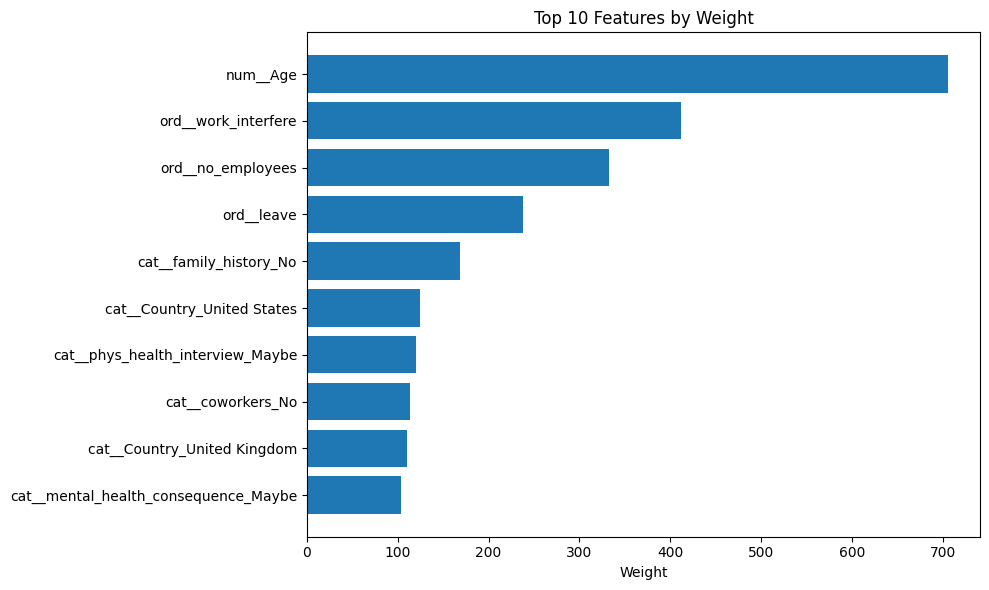

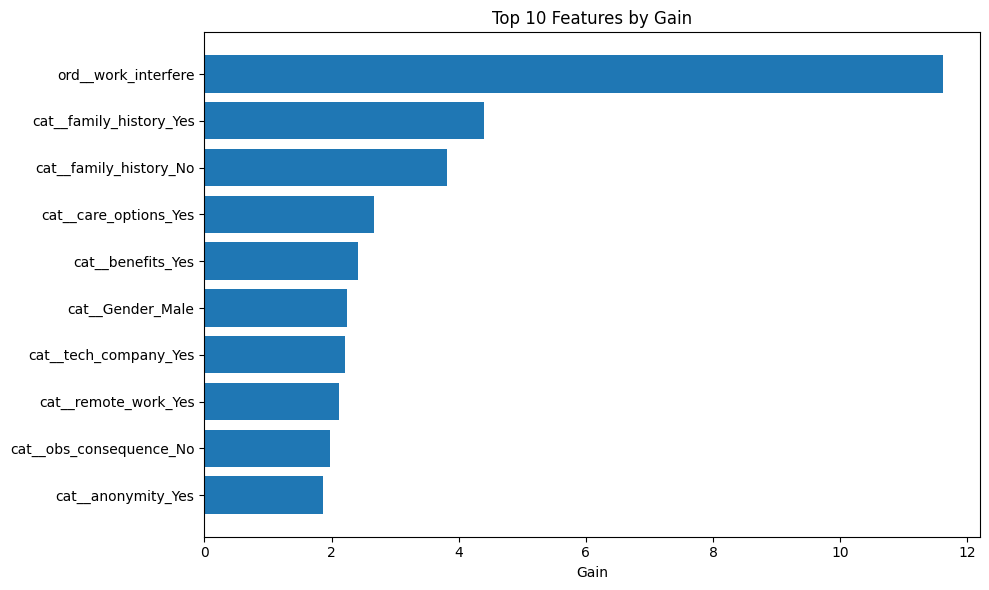

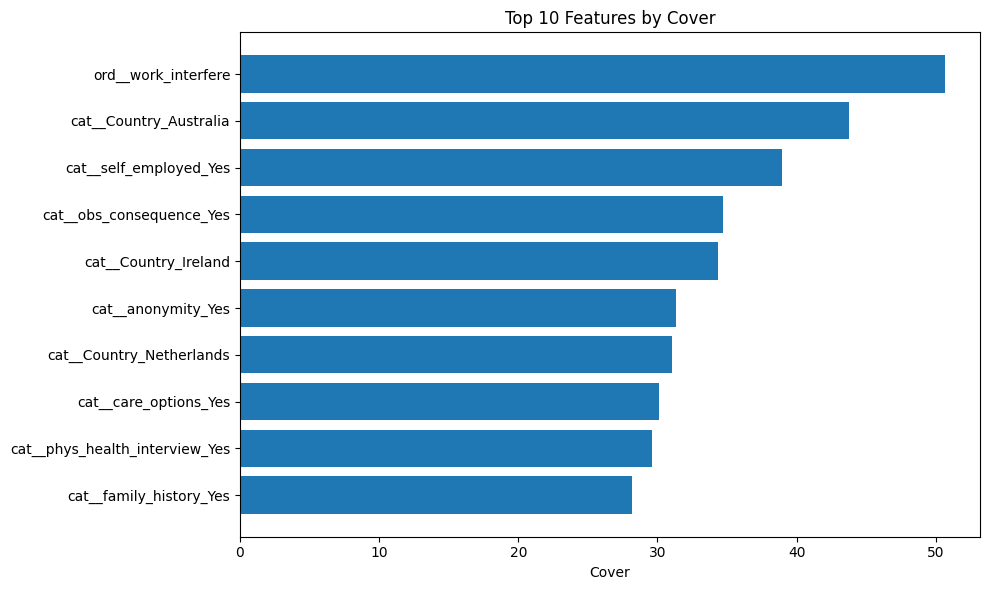

In [21]:
metrics = ['weight', 'gain', 'cover']
feature_importances = {metric: model.get_booster().get_score
                       (importance_type=metric) for metric in metrics}

importance_df = {}
for metric, values in feature_importances.items():
    df = pd.DataFrame(values.items(), 
                      columns=['Feature', metric.capitalize()])
    df = df.sort_values(by=metric.capitalize(), 
                        ascending=False).head(10)  # Top 10 features
    importance_df[metric] = df
    
for metric, df in importance_df.items():
    plt.figure(figsize=(10, 6))
    plt.barh(df['Feature'], df[metric.capitalize()], align='center')
    plt.xlabel(metric.capitalize())
    plt.title(f"Top 10 Features by {metric.capitalize()}")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.tight_layout()
    filename = f'Feature_importance_by_{metric}.png'
    plt.savefig(filename, dpi=500)
    plt.show()

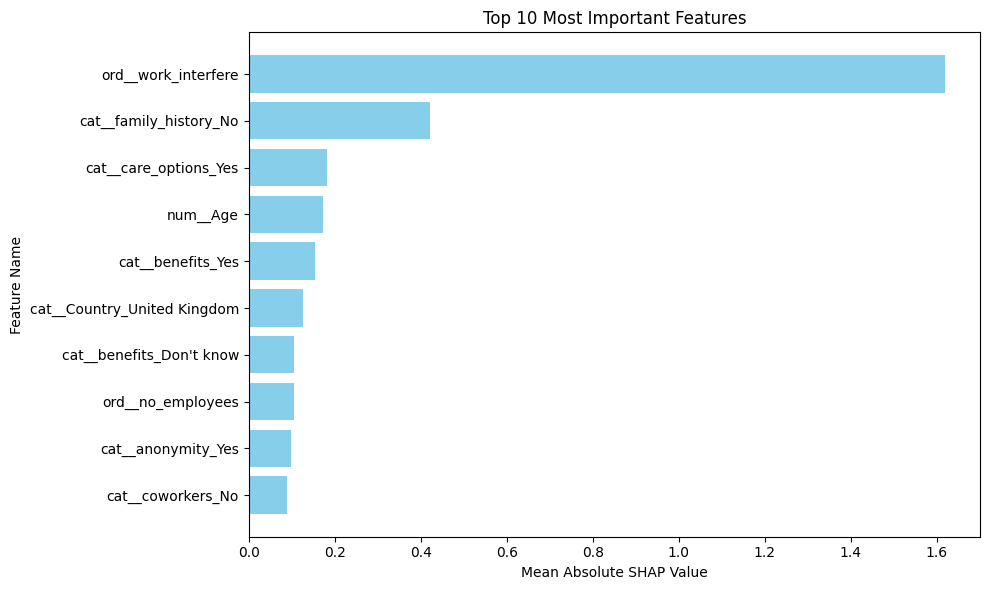

In [14]:
import shap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

sorted_indices = np.argsort(mean_abs_shap_values)[::-1]  
top_10_indices = sorted_indices[:10]  
top_10_features = [feature_names[i] for i in top_10_indices]
top_10_importances = mean_abs_shap_values[top_10_indices]

importance_df = pd.DataFrame({
    'Feature': top_10_features,
    'Mean Absolute SHAP Value': top_10_importances
})

plt.figure(figsize=(10, 6))
plt.barh(top_10_features[::-1], top_10_importances[::-1], 
         color='skyblue')  
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature Name")
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.savefig('Mean_|SHAP|_value.png', dpi = 500)
plt.show()


Force plot for index 0:


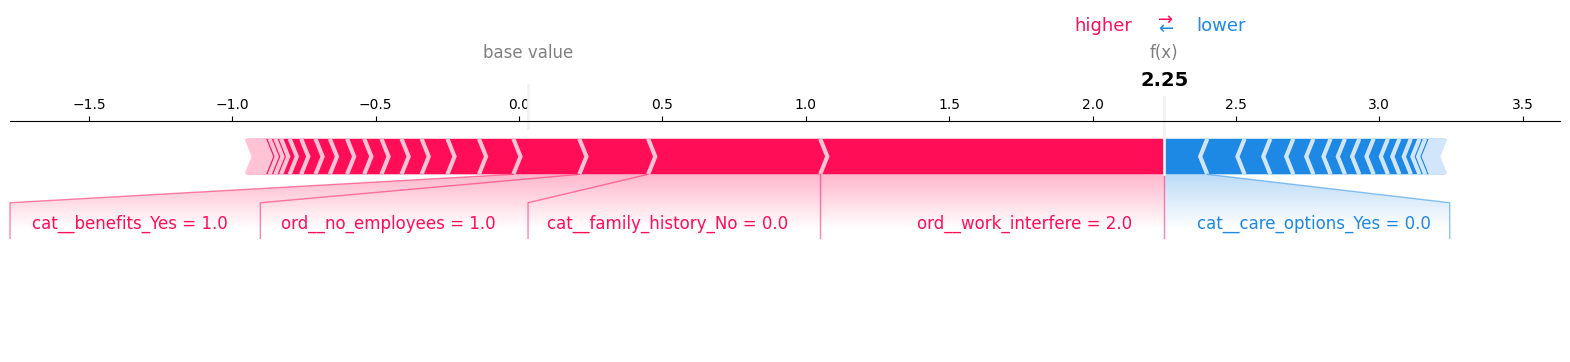

<Figure size 640x480 with 0 Axes>

Force plot for index 100:


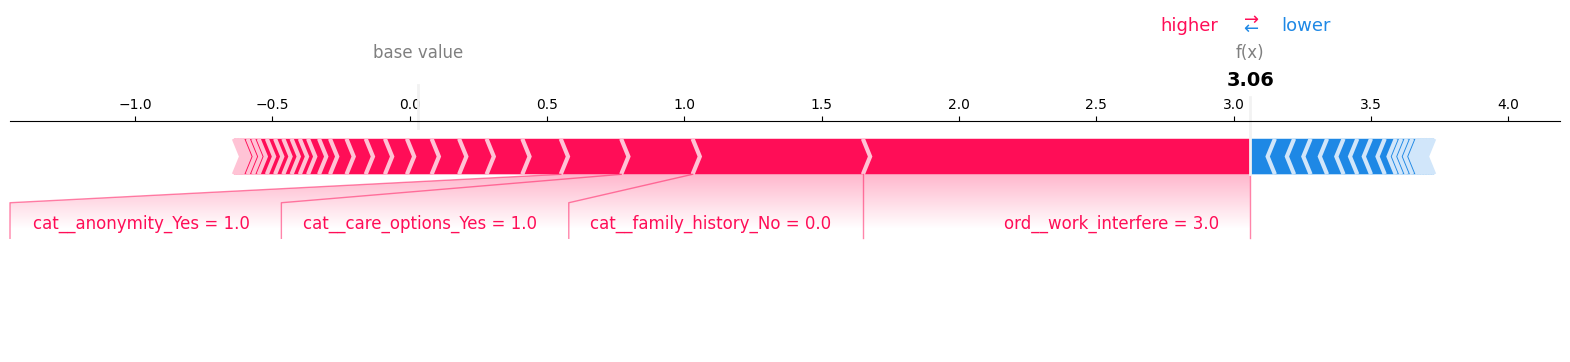

<Figure size 640x480 with 0 Axes>

Force plot for index 200:


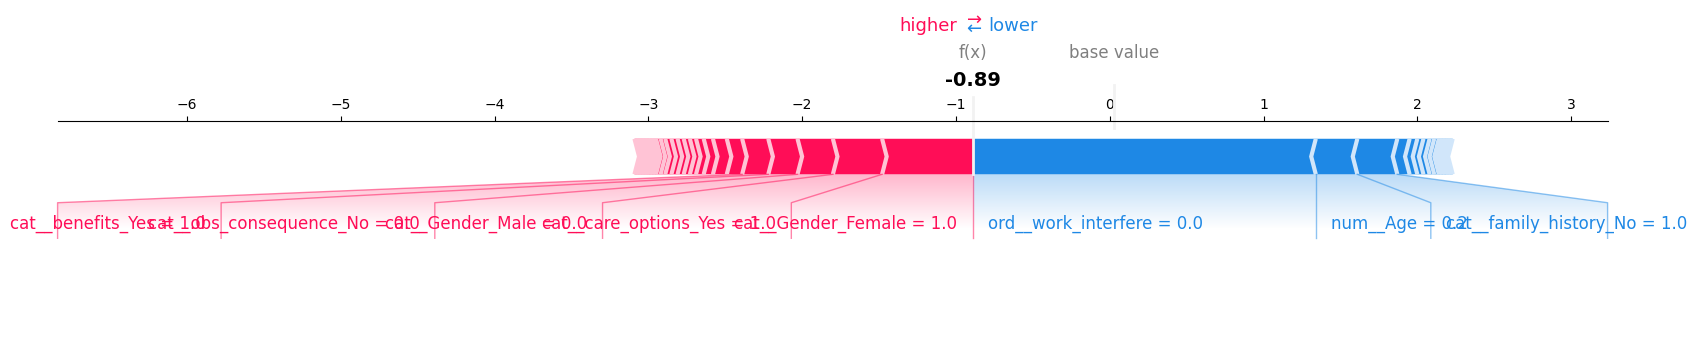

<Figure size 640x480 with 0 Axes>

In [25]:
# your code here
import shap
import matplotlib.pyplot as plt

dmatrix_test = xgboost.DMatrix(df_test, enable_categorical = True)

# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dmatrix_test)

indices = [0, 100, 200]

for i in indices:
    print(f"Force plot for index {i}:")
    shap.force_plot(
        np.around(explainer.expected_value, decimals = 2),    
        np.around(shap_values[i], decimals = 2),              
        np.around(df_test.iloc[i, :], decimals = 2),          
        matplotlib=True              
    )
    filename = f'Forceplot_{i}.png'
    plt.savefig(filename, dpi=500)
    plt.show()

    